In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import pickle
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer

In [2]:
feats = pd.read_csv("../System/feats_train.csv")

af = feats.loc[feats['class'] == 1]
naf = feats.loc[feats['class'] == 0]

labels = feats["class"]
feats.drop('class', axis=1, inplace=True)

feats.head()

,superlatives,degree_adverbs,comparative_adverbs,proper_nouns,dates,numbers,fp_pronouns,negations,pos_emotion,neg_emotion,...,readability,ap_num,ap_date,ap_title,alliteration,profanity,lexical_diversity,lexical_density,function_words,spelling_errors
0,0.002488,0.200000,0.133333,0.224000,0.000000,0.012438,0.230769,0.000000,0.009950,0.014925,...,0.606467,0.0,1.0,1.0,0.000000,0.000000,0.613692,0.589242,0.410758,0.029340
1,0.000000,0.047619,0.047619,0.170940,0.000000,0.000000,0.545455,0.010471,0.002618,0.005236,...,0.595667,0.0,1.0,1.0,0.166667,0.002577,0.590206,0.597938,0.402062,0.064433
2,0.004255,0.111111,0.000000,0.163934,0.017021,0.008511,0.125000,0.017021,0.017021,0.004255,...,0.593667,0.0,1.0,1.0,0.000000,0.000000,0.566667,0.575000,0.425000,0.016667
3,0.000000,0.083333,0.000000,0.266667,0.000000,0.037037,0.000000,0.005291,0.015873,0.000000,...,0.517600,1.0,1.0,0.0,0.666667,0.000000,0.708333,0.604167,0.395833,0.156250
4,0.002066,0.000000,0.000000,0.152866,0.004132,0.035124,0.555556,0.002066,0.004132,0.006198,...,0.697400,1.0,1.0,1.0,0.000000,0.000000,0.529532,0.610998,0.389002,0.042770


In [3]:
groups = ["complexity", "deception", "details", "formality"
                  ,"humour", "imagination", "vagueness"]

colour_map = {"complexity":"b", "deception":"g", "details":"r", "formality":"c"
                  ,"humour":"m", "imagination":"y", "vagueness":"k"}

feat_group_map = dict()

for g in groups:
    with open("../System/feature_sets/{}.txt".format(g)) as file:
        for line in file:
            if line.strip() in feats.columns:
                feat_group_map[line.strip()] = g

In [4]:
classifier = LogisticRegression()

pipeline = Pipeline([
        ('normalizer', StandardScaler()),  # Step1 - normalize data
#         ('normalizer', RobustScaler(quantile_range=(25, 75))),  # Step1 - normalize data
        ('clf', classifier)  # Step2 - classifier
        ])

pipeline.fit(feats, labels)

Pipeline(memory=None,
     steps=[('normalizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [5]:
def get_weights(CLF, feats=feats):
    svc_coeffs = CLF.coef_.ravel()

    rank_pd = pd.DataFrame()
    rank_pd['Weights'] = svc_coeffs
    rank_pd['Features'] = feats.columns.values
    rank_pd.set_index("Features", inplace=True)
    sorted_ranks = rank_pd.sort_values(by='Weights', ascending=False)
    return sorted_ranks
    
sorted_ranks = get_weights(classifier)

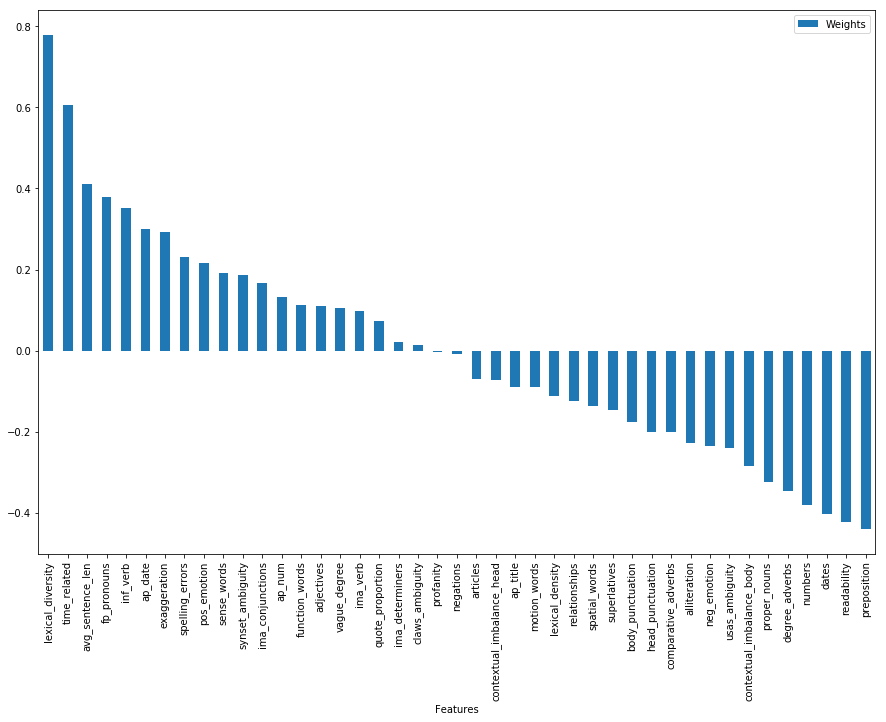

In [6]:
sorted_ranks.plot(kind='bar', figsize=(15,10))
sorted_ranks['group'] = [feat_group_map[feat] for feat in sorted_ranks.index.values]
plt.show()

In [7]:
# Sort the data by absolute value of svm weight
sorted_data = sorted_ranks.assign(f=abs(sorted_ranks['Weights']))\
    .sort_values(by='f', ascending=False)\
    .drop('f', axis=1)
sorted_data = sorted_data.round(3)
sorted_data.head(10)

,Weights,group
Features,,
lexical_diversity,0.778,complexity
time_related,0.607,details
preposition,-0.440,imagination
readability,-0.423,complexity
avg_sentence_len,0.410,complexity
dates,-0.403,details
numbers,-0.381,details
fp_pronouns,0.378,deception
inf_verb,0.351,imagination


In [8]:
print(sorted_data.head(10).to_latex())

\begin{tabular}{lrl}
\toprule
{} &  Weights &        group \\
Features          &          &              \\
\midrule
lexical\_diversity &    0.778 &   complexity \\
time\_related      &    0.607 &      details \\
preposition       &   -0.440 &  imagination \\
readability       &   -0.423 &   complexity \\
avg\_sentence\_len  &    0.410 &   complexity \\
dates             &   -0.403 &      details \\
numbers           &   -0.381 &      details \\
fp\_pronouns       &    0.378 &    deception \\
inf\_verb          &    0.351 &  imagination \\
degree\_adverbs    &   -0.347 &    vagueness \\
\bottomrule
\end{tabular}



In [9]:
sorted_data.loc[sorted_data['group']=='vagueness']

,Weights,group
Features,,
degree_adverbs,-0.347,vagueness
exaggeration,0.291,vagueness
usas_ambiguity,-0.241,vagueness
comparative_adverbs,-0.201,vagueness
synset_ambiguity,0.187,vagueness
superlatives,-0.145,vagueness
vague_degree,0.104,vagueness
claws_ambiguity,0.015,vagueness


In [10]:
temp = sorted_data.copy()
temp["Weights"] = temp["Weights"].abs()

lr_groups = temp.groupby('group').sum()
lr_groups['mean'] = temp.groupby('group').mean()
lr_groups['count'] = temp.groupby('group').count()

lr_groups

,Weights,mean,count
group,,,
complexity,2.283,0.285375,8
deception,0.622,0.207333,3
details,2.133,0.304714,7
formality,0.751,0.187750,4
humour,0.927,0.154500,6
imagination,1.256,0.179429,7
vagueness,1.531,0.191375,8


In [11]:
sca_feats = StandardScaler().fit_transform(feats)
classifier.fit(sca_feats, labels)
pred = classifier.predict(sca_feats)
probs = classifier.predict_proba(sca_feats)

In [39]:
column_names = ["Index", "URL", "Headline", "Year", "Category", "April Fool", "Set"]
meta = pd.read_csv("../Corpus Construction/meta.csv", delimiter=";", header=None, names=column_names)
meta.set_index('Index', inplace=True)

meta = meta.loc[:, ['Headline']]
meta["Truth"] = labels
meta["Prediction"] = pred
meta["Prob Est NAF"] = probs[:, 0]
meta["Prob Est AF"] = probs[:, 1]

errors = meta.loc[meta.Truth != meta.Prediction]
correct = meta.loc[meta.Truth == meta.Prediction]

In [40]:
errors

,Headline,Truth,Prediction,Prob Est NAF,Prob Est AF
Index,,,,,
3,Cold war bomb warmed by chickens,1.0,0,0.509092,0.490908
6,Zabel asks for height regulations to podiums,1.0,0,0.674380,0.325620
11,Tiger Woods signs long-term deal with Apple Co...,1.0,0,0.520796,0.479204
13,"New York City Stunned By Seth Godin's ""Bloggin...",1.0,0,0.551457,0.448543
19,Water On Mars,1.0,0,0.656841,0.343159
23,Bush twins to join Air Force tech unit in Iraq,1.0,0,0.773728,0.226272
24,AI Has Been Solved,1.0,0,0.623450,0.376550
25,Intel Wants Off Open Source Listing,1.0,0,0.755914,0.244086
29,Chris Farley returns in ad campaign,1.0,0,0.556639,0.443361
